In [2]:
from tri_raster import *
import numpy as np

In [3]:
def random_tri(bounds):
    C,R = bounds
    tri = np.random.uniform(0,1,(3,2))
    tri[:,0] *= C[1]
    tri[:,0] += C[0]
    tri[:,1] *= R[1]
    tri[:,1] += R[0]
    tri = tri.astype(int)
    tri_points = [(tri[i,0],tri[i,1]) for i in range(3)]
    return tri_points

## the following cell takes a while to run!
if you don't want to wait, use the pre-recorded output.

In [11]:
from time import time
from random import randint
K = 5
T = 1000
AREA = []
TIME = []
POINTS = []
for k in range(K):
    b = 10 * (4**k)
    print(b)
    bounds = ((0,b),(0,b))
    acc_area = 0.0
    acc_time = 0.0
    acc_points = 0
    for t in range(T):
        tri = random_tri(bounds)
        area = tri_area(np.array(tri))
        if area < 3:
            t -= 1
            continue
        si = time()
        points = fill_tri_3(tri)
        sf = time()
        acc_area += area
        acc_time += sf - si
        acc_points += len(points)
        if t > 0 and t % (T//10) == 0 and T >= 500:
            print("{:.2f}".format(t/T), end=' ')
    AREA.append(acc_area / T)
    TIME.append(acc_time / T)
    POINTS.append(acc_points / T)
    print()
print(TIME, AREA, POINTS)

10
0.10 0.20 0.30 0.40 0.50 
40
0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 
160
0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 
640
0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 
2560
0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 
[0.0004097104072570801, 0.0018774173259735107, 0.01667259669303894, 0.2396823592185974, 3.677230579853058] [7.2805, 126.2355, 1883.3675, 30108.6635, 481324.0715] [9.212, 135.765, 1917.087, 30226.466, 481785.95]


In [ ]:
# run me if you don't want to wait
TIME = [0.0004097104072570801, 0.0018774173259735107, 0.01667259669303894, 0.2396823592185974, 3.677230579853058] 
AREA = [7.2805, 126.2355, 1883.3675, 30108.6635, 481324.0715] 
POINTS = [9.212, 135.765, 1917.087, 30226.466, 481785.95]

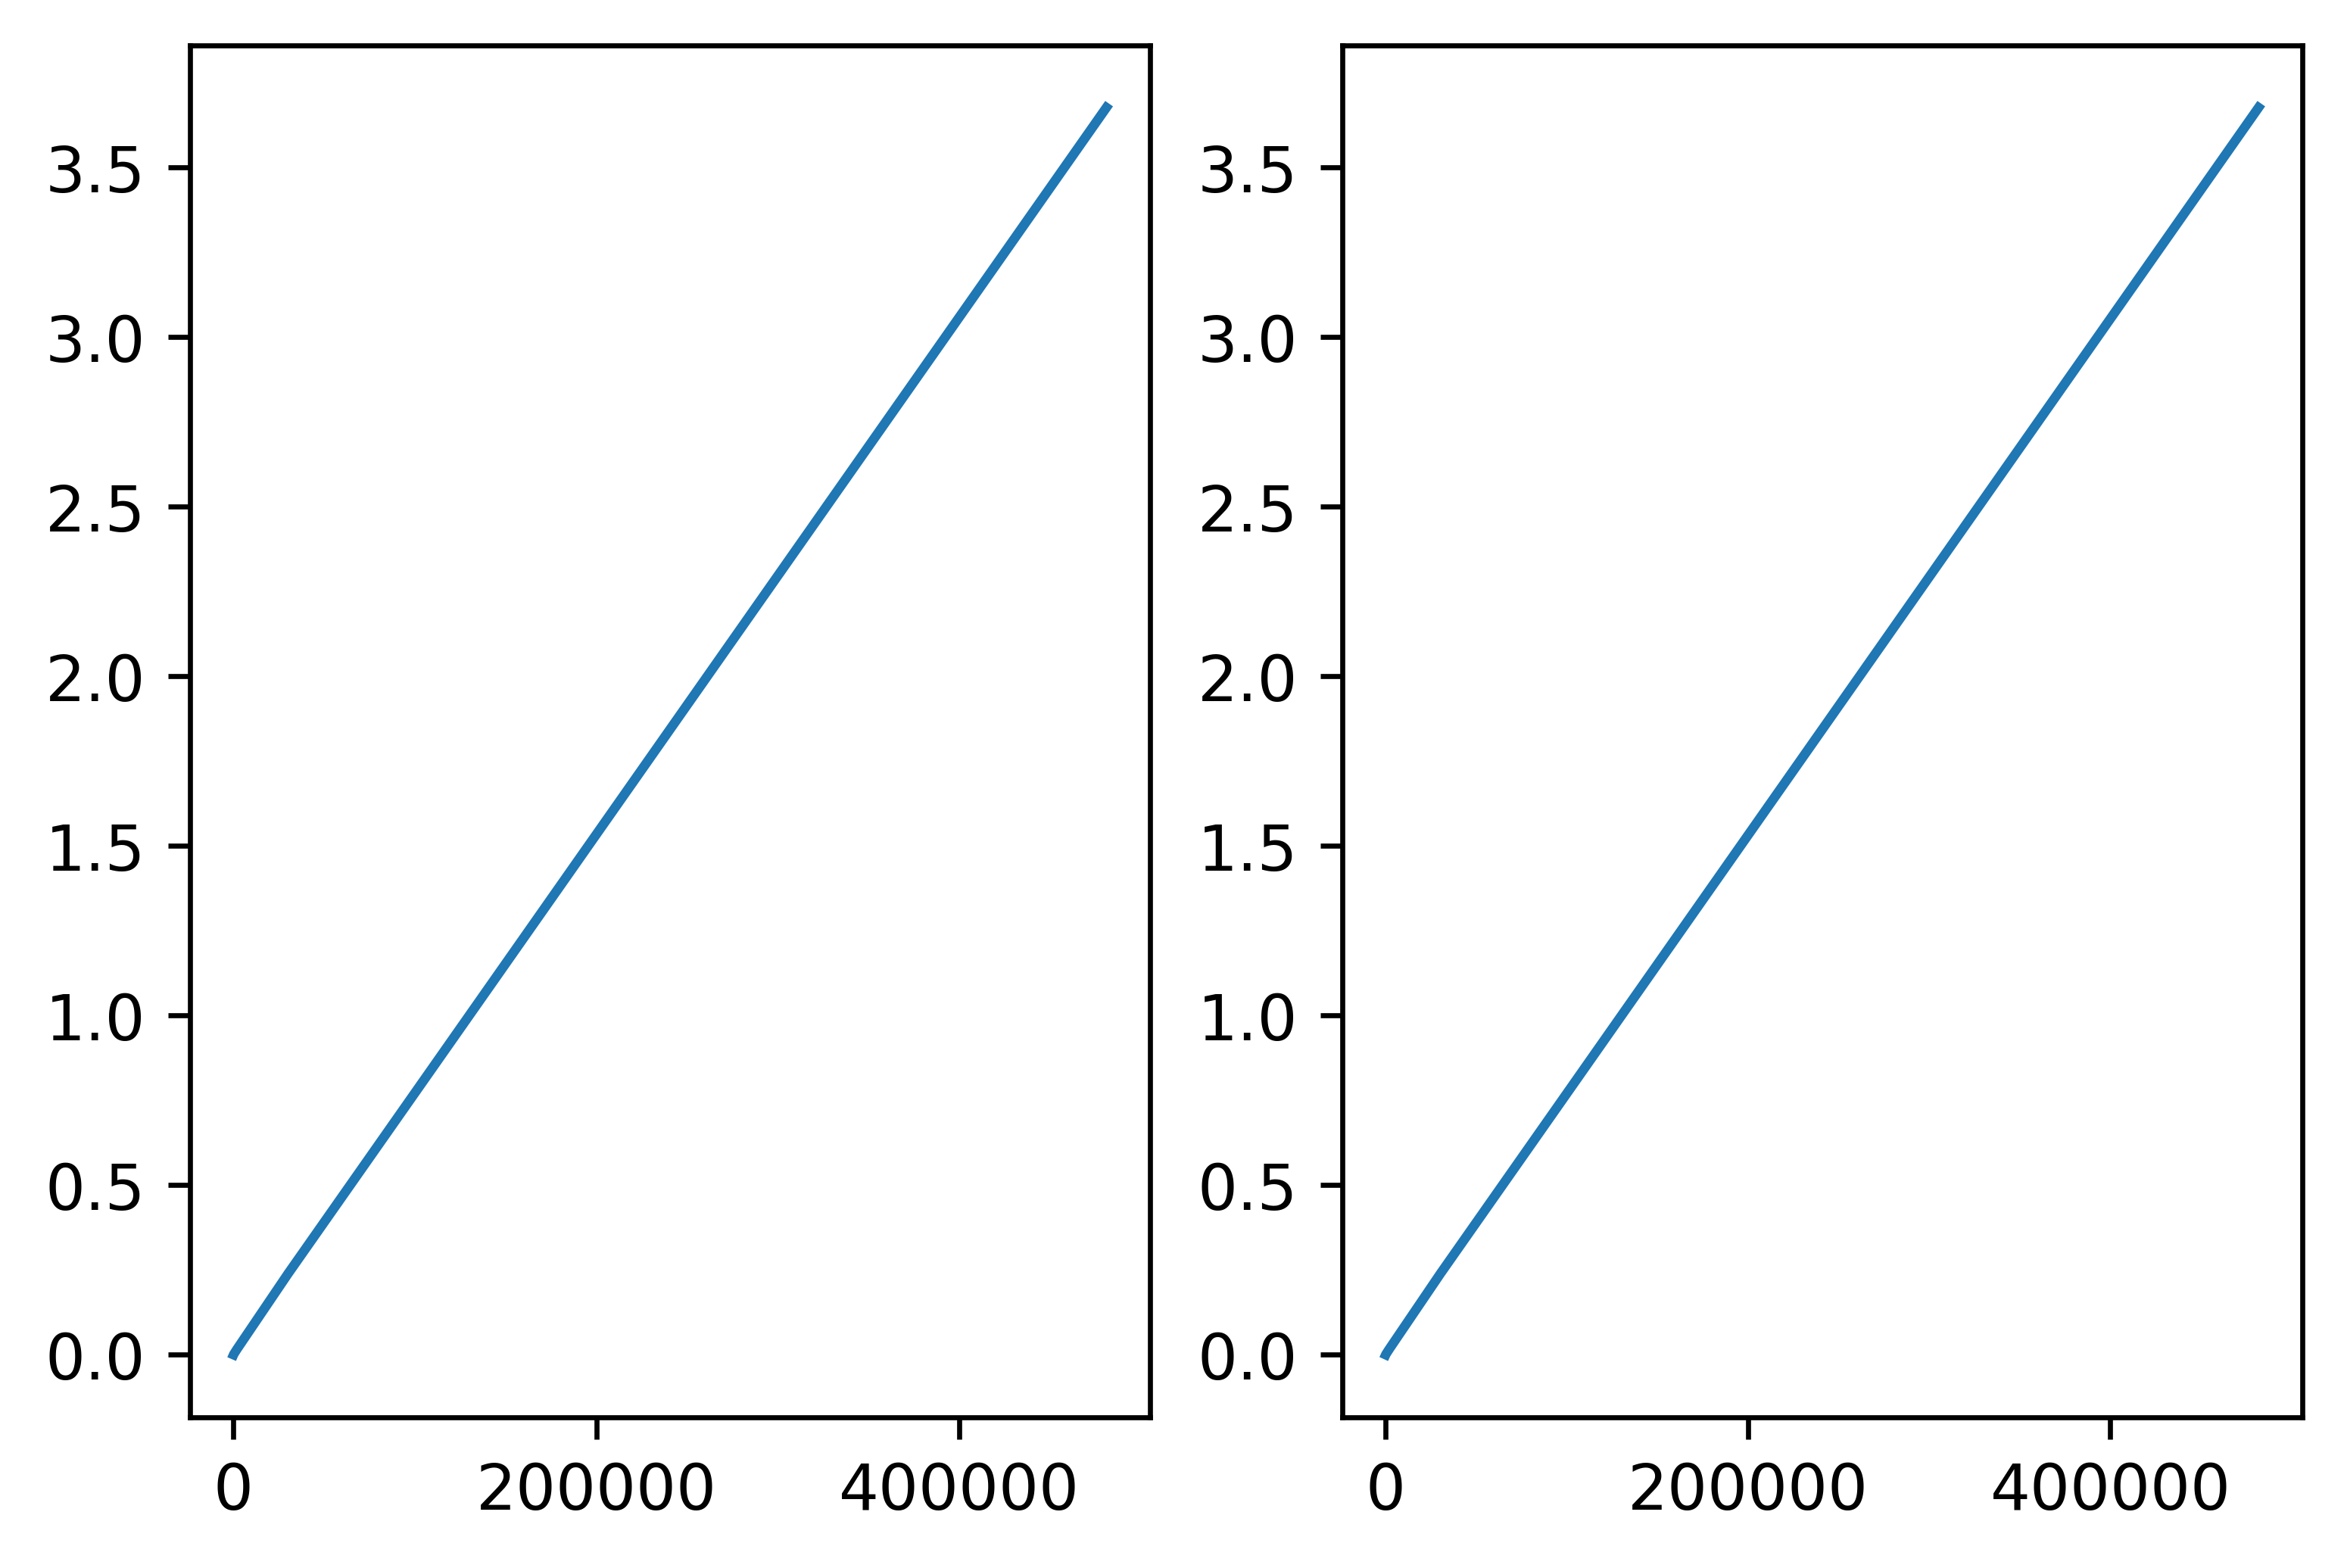

In [13]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=2, dpi=600)
ax[0].plot(AREA, TIME)
ax[1].plot(POINTS, TIME)

### metadata
there are $\big| \{ 1,2,3 \} \times \{ 0,1 \} \times \{ -1, 1\} \big| = 12$ configurations of the tri-bresenham routine, and no one configuration works for every triangle, or even a plurality of triangles.

In [ ]:
def fill_tri_meta(tri,verbose=False):
    """
    metadata
    """
    a,b,c = tri
    # locate the longest side `ax` of the triangle
    sides = [(a,b),(b,c),(c,a)]
    P = []
    for ax_idx in [0,1,2]:
        ax = sides[ax_idx]
        ax_ang = angle(ax[0],ax[1])
        # find the vertex opposing `ax`
        c1,c2 = sides[ax_idx-1],sides[ax_idx-2]
        assert c1[0] == c2[1]
        t = c1[0]
        # orient the triangle to an axis (per the closest to `ax`)
        if np.pi/4 <= ax_ang < 3*np.pi/4 or -3*np.pi/4 <= ax_ang < -np.pi/4:
            orientation = 1
        else:
            orientation = 0
        for orientation in [0,1]:
            # find the line containing `ax`
            f = get_eq(ax,orientation,verbose=verbose)
            # determine the parity of the triangle
            for parity in [-1,1]:
                if verbose:
                    print('axial:\t\t',ax)
                    print('angle:\t\t',ax_ang)
                    print('third:\t\t',t)
                    print('orientation:\t',orientation)
                    print('parity:\t\t',parity)
                # lines containing the other two sides of the triangle
                g = get_eq(c1,orientation,verbose=verbose)
                h = get_eq(c2,orientation,verbose=verbose)
                # build constraints with regard to the oriented side
                under_g = constraint(g, orientation, parity)
                under_h = constraint(h, orientation, parity)
                # the points above f and below g,h - which makes up the whole triangle!
                points = tri_bresenham(ax, orientation, parity,
                                       constraint=lambda x: under_g(x) and under_h(x),
                                       verbose=verbose)
                if len(points) > 1:
                    P.append((len(points),
                              tri_area(np.array(tri)),
                              tri,
                              (ax,orientation,parity)))
    return P

In [ ]:
T = 1000
bounds = [[10,200],[10,200]]
results = []
for t in range(T):
    tri = random_tri(bounds)
    results.append(fill_tri_meta(tri))
    if t % (T//10) == 0:
        print("{:0.2f}".format(t/T))

In [ ]:
curated = []
for x in results:
    errors = [abs(y[0]-y[1]) for y in x]
    nearest = np.argmin(errors)
    print("tri:",x[nearest])
    print("error: {:.2f}".format(errors[nearest]/x[nearest][1]))
    print()
    curated.append((errors[nearest]/x[nearest][1],x[nearest]))

In [ ]:
curated = sorted(curated,key=lambda x:-x[0])
curated[:5]
# the only apparent degenerate case occurs when all the vertices occur near a common line 